In [5]:
import os
os.makedirs('/tmp/spark-events', exist_ok=True)

In [6]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

# Stop any existing context
try:
    SparkContext.getOrCreate().stop()
except:
    pass

# Now create a new session
spark = SparkSession.builder.appName("LinearRegression").getOrCreate()

25/12/25 20:20:42 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:59)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:77)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:481)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.command

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [9]:
df_train = spark.read.csv("data/train.csv", header=True, inferSchema=True)

In [11]:
df_fe = (
    df_train
    # --- Feature Engineering ---
    .withColumn("is_night", (F.lower(F.col("lighting")) == "night").cast("int"))
    .withColumn("lighting_bin", F.when(F.lower(F.col("lighting")) == "night", "Night").otherwise("Not_Night"))
    .withColumn("bad_visibility", 
                ((F.lower(F.col("lighting")) == "night") & 
                 (F.lower(F.col("weather")) == "foggy")).cast("int"))
    .withColumn("curvature_x_weather", 
                F.col("curvature") * F.lower(F.col("weather")).isin("rainy", "foggy", "snowy", "stormy").cast("int"))
    
    # --- Chuẩn hóa kiểu dữ liệu ---
    .withColumn("road_signs_present", F.col("road_signs_present").cast("int"))
    .withColumn("public_road", F.col("public_road").cast("int"))
    .withColumn("holiday", F.col("holiday").cast("int"))
    .withColumn("school_season", F.col("school_season").cast("int"))
    .drop("id") # Loại bỏ id vì không có giá trị dự báo
)

categorical_cols = ["road_type", "lighting_bin", "time_of_day"]
numeric_cols  = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents", 
                  "is_night", "bad_visibility", "curvature_x_weather",
                  "road_signs_present", "public_road", "holiday", "school_season"]
target_col = "accident_risk"

# 1. SPLIT DATA 
train_df, test_df = df_fe.randomSplit([0.8, 0.2], seed=42)


# 2. STRING INDEXER
indexers = [
    StringIndexer(
        inputCol=c,
        outputCol=f"{c}_idx",
        handleInvalid="keep"
    )
    for c in categorical_cols
]

# 3. ONE-HOT ENCODER
encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in categorical_cols],
    outputCols=[f"{c}_vec" for c in categorical_cols],
    dropLast=True,
    handleInvalid="keep"
)

# 4. ASSEMBLE + SCALE NUMERIC ONLY
num_assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="num_features",
    handleInvalid="keep"
)

num_scaler = StandardScaler(
    inputCol="num_features",
    outputCol="num_scaled",
    withStd=True,
    withMean=True      
)

# 5. FINAL ASSEMBLER
final_assembler = VectorAssembler(
    inputCols=[f"{c}_vec" for c in categorical_cols] + ["num_scaled"],
    outputCol="features"
)

# 6. LINEAR REGRESSION
lr = LinearRegression(
    featuresCol="features",
    labelCol=target_col
)

# ===============================
# 7. PIPELINE
# ===============================
pipeline = Pipeline(
    stages=indexers
           + [encoder,
              num_assembler,
              num_scaler,
              final_assembler,
              lr]
)

# 8. TRAIN
model = pipeline.fit(train_df)

# 9. PREDICT
pred_train = model.transform(train_df)
pred_test  = model.transform(test_df)

# 10. EVALUATE
evaluator_r2 = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="r2"
)

evaluator_mae = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="mae"
)

evaluator_rmse = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="rmse"
)

# ===== Train =====
train_r2 = evaluator_r2.evaluate(pred_train)
train_mae = evaluator_mae.evaluate(pred_train)
train_rmse = evaluator_rmse.evaluate(pred_train)

# ===== Test =====
test_r2 = evaluator_r2.evaluate(pred_test)
test_mae = evaluator_mae.evaluate(pred_test)
test_rmse = evaluator_rmse.evaluate(pred_test)

metrics = {
    "train_r2": train_r2,
    "train_mae": train_mae,
    "train_rmse": train_rmse,
    "test_r2": test_r2,
    "test_mae": test_mae,
    "test_rmse": test_rmse,
}

metrics

print("===== METRICS =====")
for k, v in metrics.items():
    print(f"{k}: {v:.5f}")


25/12/25 20:27:29 WARN Instrumentation: [81a1377c] regParam is zero, which might cause numerical instability and overfitting.
25/12/25 20:27:30 WARN Instrumentation: [81a1377c] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


===== METRICS =====
train_r2: 0.79076
train_mae: 0.06063
train_rmse: 0.07612
test_r2: 0.79121
test_mae: 0.06068
test_rmse: 0.07605


In [12]:
# 11. XEM DỰ ĐOÁN
# ===============================
pred_test.select(target_col, "prediction").show(10, truncate=False)

+-------------+--------------------+
|accident_risk|prediction          |
+-------------+--------------------+
|0.13         |0.062179200488717   |
|0.04         |0.1292983045054378  |
|0.45         |0.4351194186938524  |
|0.06         |0.014185242743736282|
|0.11         |0.0807843472016812  |
|0.02         |0.06604278590562496 |
|0.01         |0.11532618107776899 |
|0.04         |0.11564180642225264 |
|0.2          |0.205904815980122   |
|0.29         |0.22370291469828787 |
+-------------+--------------------+
only showing top 10 rows


/tmp/ipykernel_5796/1310388415.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance.head(15), x='Coefficient', y='Feature', palette='magma')


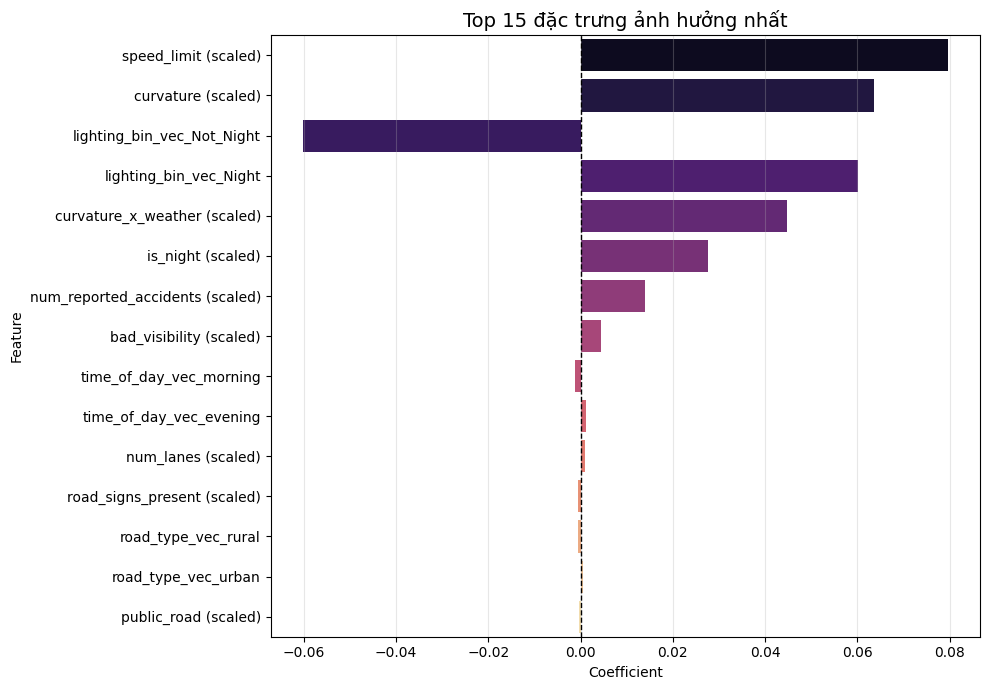

                        Feature  Coefficient
           speed_limit (scaled)     0.079578
             curvature (scaled)     0.063628
     lighting_bin_vec_Not_Night    -0.060182
         lighting_bin_vec_Night     0.060182
   curvature_x_weather (scaled)     0.044646
              is_night (scaled)     0.027613
num_reported_accidents (scaled)     0.014016
        bad_visibility (scaled)     0.004451
        time_of_day_vec_morning    -0.001128
        time_of_day_vec_evening     0.001097
             num_lanes (scaled)     0.000890
    road_signs_present (scaled)    -0.000578
            road_type_vec_rural    -0.000515
            road_type_vec_urban     0.000485
           public_road (scaled)    -0.000378


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Trích xuất và ánh xạ tên đặc trưng từ Metadata
transformed_df = model.transform(train_df.limit(1))
attrs = transformed_df.schema["features"].metadata["ml_attr"]["attrs"]
lr_model = model.stages[-1]
final_names = [None] * len(lr_model.coefficients)

for group in attrs:
    for attr in attrs[group]:
        idx = attr["idx"]
        name = attr["name"]
        
        if name.startswith("num_scaled_"):
            num_idx = int(name.split("_")[-1])
            final_names[idx] = f"{numeric_cols[num_idx]} (scaled)"
        else:
            final_names[idx] = name

# 2. Tạo DataFrame kết quả
df_importance = pd.DataFrame({
    'Feature': final_names,
    'Coefficient': lr_model.coefficients.toArray()
})
df_importance['Abs_Coefficient'] = df_importance['Coefficient'].abs()
df_importance = df_importance.sort_values(by='Abs_Coefficient', ascending=False)

# 3. Trực quan hóa
plt.figure(figsize=(10, 7))
sns.barplot(data=df_importance.head(15), x='Coefficient', y='Feature', palette='magma')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.title("Top 15 đặc trưng ảnh hưởng nhất", fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. In bảng dữ liệu
print(df_importance[['Feature', 'Coefficient']].head(15).to_string(index=False))

In [17]:
model_path = "accident_risk_pipeline_v1"
model.write().overwrite().save(model_path)